In [1]:
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from IPython.core.display import display, HTML
import shap
import sys; sys.path.insert(0, '../..')
import math
import pandas as pd
from Server.NeuralNetwork.neuralnet import NeuralNet
from Server.DataAccess.MongoDBConnection import MongoDBConnection

shap.initjs()

'Dictionary for the class values and their names'

In [2]:
Label_to_value_dict={'X':0,
                     '1':1,
                     '2':2}

value_to_label_dict={0:'X',
                     1:'1',
                     2:'2'}
columns_convertor={'result_0':'X',
                   'result_1':'1',
                   'result_2':'2'}
projection_dict={'_id': False,
                #'league' : True,
                #'date' : True,
                'round' : False,
                #'home_team_name' : True,
                #'away_team_name' : True,
                'home_odds_nn':False,
                'draw_odds_nn':False,
                'away_odds_nn':False}

 Loading and spliting the data

In [3]:
COLUMNS_NAMES=['home_team_rank', 'away_team_rank', 'home_avg_scored', 'home_avg_received', 'away_avg_scored',
               'away_avg_received', 'home_att', 'away_att', 'home_def', 'away_def', 'home_mid', 'away_mid',
               'home_avg_shots', 'away_avg_shots', 'home_avg_shots_on_target', 'away_avg_shots_on_target',
               'home_avg_corners', 'away_avg_corners', 'home_avg_fouls', 'away_avg_fouls', 'home_avg_yellow_cards',
               'away_avg_yellow_cards', 'home_avg_red_cards', 'away_avg_red_cards', 'home_odds_n', 'draw_odds_n',
               'away_odds_n', 'home_odds_nn', 'draw_odds_nn', 'away_odds_nn', 'result']

FEATURES_NAME=['home_team_rank', 'away_team_rank', 'home_avg_scored', 'home_avg_received', 'away_avg_scored',
               'away_avg_received', 'home_att', 'away_att', 'home_def', 'away_def', 'home_mid', 'away_mid',
               'home_avg_shots', 'away_avg_shots', 'home_avg_shots_on_target', 'away_avg_shots_on_target',
               'home_avg_corners', 'away_avg_corners', 'home_avg_fouls', 'away_avg_fouls', 'home_avg_yellow_cards',
               'away_avg_yellow_cards', 'home_avg_red_cards', 'away_avg_red_cards', 'home_odds_n', 'draw_odds_n',
               'away_odds_n']




In [4]:
#connect to mongoDB
connection = MongoDBConnection(mode='explore')


In [5]:
#Load the data

data= pd.DataFrame.from_records(connection.MainTable.find({ 'home_avg_scored': { '$gt': -1 } },
                                                          projection=projection_dict)
                                                        .limit(20000))
print(list(data.columns))
display(data.head())
X=data.loc[:,FEATURES_NAME]
Y=data.loc[:,'result':'result']

['league', 'date', 'home_team_name', 'away_team_name', 'home_team_rank', 'away_team_rank', 'home_avg_scored', 'home_avg_received', 'away_avg_scored', 'away_avg_received', 'home_att', 'away_att', 'home_def', 'away_def', 'home_mid', 'away_mid', 'home_avg_shots', 'away_avg_shots', 'home_avg_shots_on_target', 'away_avg_shots_on_target', 'home_avg_corners', 'away_avg_corners', 'home_avg_fouls', 'away_avg_fouls', 'home_avg_yellow_cards', 'away_avg_yellow_cards', 'home_avg_red_cards', 'away_avg_red_cards', 'home_odds_n', 'draw_odds_n', 'away_odds_n', 'result']


,league,date,home_team_name,away_team_name,home_team_rank,away_team_rank,home_avg_scored,home_avg_received,away_avg_scored,away_avg_received,...,home_avg_fouls,away_avg_fouls,home_avg_yellow_cards,away_avg_yellow_cards,home_avg_red_cards,away_avg_red_cards,home_odds_n,draw_odds_n,away_odds_n,result
0,Laliga,2005-05-11,Espanol,Ath Bilbao,18,19,1.000000,1.666667,1.000000,1.666667,...,17.333333,18.000000,2.000000,2.666667,0.000000,0.333333,0.443938,0.284398,0.271664,X
1,Laliga,2005-05-11,Sociedad,Osasuna,11,2,1.333333,1.666667,1.666667,0.666667,...,17.666667,21.333333,2.666667,3.000000,0.333333,0.000000,0.439489,0.284578,0.275933,2
2,Laliga,2005-05-11,Villarreal,Valencia,6,7,1.333333,1.000000,1.333333,1.333333,...,15.666667,20.333333,2.000000,2.333333,0.000000,0.666667,0.395447,0.289786,0.314767,1
3,PremierLeague,2005-05-11,Arsenal,Sunderland,9,19,1.333333,1.000000,1.333333,2.333333,...,13.000000,14.666667,0.666667,1.333333,0.000000,0.000000,0.753458,0.165989,0.080553,1
4,PremierLeague,2005-05-11,Aston Villa,Liverpool,15,11,1.000000,2.000000,2.000000,1.333333,...,16.000000,14.000000,2.666667,1.333333,0.000000,0.000000,0.299143,0.291209,0.409648,2


In [6]:
#convert categorical to numerical value and encode
Y['result']=Y['result'].map(Label_to_value_dict)
Y = pd.get_dummies(Y,columns=['result'], prefix='result')
Y.rename(columns=columns_convertor,inplace=True)

In [7]:
#splitting the data to train-test datasets
Split_point=math.ceil(data.shape[0]*0.8)
x_train=X[0:Split_point]
y_train=Y[0:Split_point]

x_test=X[Split_point:]
y_test=Y[Split_point:]

feature_names=FEATURES_NAME


In [8]:
#Training the neural network
EPOCHS=40
ann=NeuralNet(x_train.shape[1])
ann.train(x_train,y_train,EPOCHS)

Batch Size:  8
Epoch 1/40
2000/2000 [==============================] - 2s 770us/step - loss: 1.2676 - accuracy: 0.4762
Epoch 2/40
2000/2000 [==============================] - 1s 734us/step - loss: 0.8996 - accuracy: 0.5893
Epoch 3/40
2000/2000 [==============================] - 1s 726us/step - loss: 0.8277 - accuracy: 0.6196
Epoch 4/40
2000/2000 [==============================] - 1s 728us/step - loss: 0.8083 - accuracy: 0.6282
Epoch 5/40
2000/2000 [==============================] - 1s 740us/step - loss: 0.7984 - accuracy: 0.6337
Epoch 6/40
2000/2000 [==============================] - 1s 734us/step - loss: 0.7936 - accuracy: 0.6356
Epoch 7/40
2000/2000 [==============================] - 1s 722us/step - loss: 0.7897 - accuracy: 0.6382
Epoch 8/40
2000/2000 [==============================] - 2s 767us/step - loss: 0.7869 - accuracy: 0.6393
Epoch 9/40
2000/2000 [==============================] - 1s 725us/step - loss: 0.7849 - accuracy: 0.6399
Epoch 10/40
2000/2000 [==========================

In [9]:
# we use the first 1000 training examples as our background dataset to integrate over
explainer = shap.DeepExplainer(ann.model,x_train.sample(1000).to_numpy())

    Force Diagrams for all classes (change sample to individual match)

In [10]:
display(HTML("<style>.container { width:100% !important; }</style>"))
import pandas as pd
number_of_samples = 1
# the sample should change to the match's feature to be explained
sample = x_test.sample(number_of_samples)
result=y_test.loc[sample.index]
prediction=pd.DataFrame(data=ann.predict(sample),index=sample.index,columns=['pred_X','pred_1','pred_2'])
print('Sample')
display(sample)
print('Actual Result')
display(result)
print('Prediction')
display(prediction)


Sample


,home_team_rank,away_team_rank,home_avg_scored,home_avg_received,away_avg_scored,away_avg_received,home_att,away_att,home_def,away_def,...,away_avg_corners,home_avg_fouls,away_avg_fouls,home_avg_yellow_cards,away_avg_yellow_cards,home_avg_red_cards,away_avg_red_cards,home_odds_n,draw_odds_n,away_odds_n
19833,20,11,1.666667,2.0,1.666667,1.333333,69,73,67,72,...,5.0,8.0,15.666667,1.666667,2.0,0.0,0.0,0.304784,0.292373,0.402843


Actual Result


,X,1,2
19833,0,0,1


Prediction


,pred_X,pred_1,pred_2
19833,0.398635,0.246169,0.355196


In [11]:
to_explain=sample.to_numpy()
shap_values = explainer.shap_values(X=to_explain,check_additivity=False)
features=to_explain
feature_names=FEATURES_NAME

for which_class in range(0,3):
    print(f'\tClass number {which_class} : {value_to_label_dict[which_class]}')
    display(shap.force_plot(base_value=explainer.expected_value[which_class].numpy(),
                            shap_values=shap_values[which_class],
                            features=features,
                            feature_names=feature_names,out_names=value_to_label_dict[which_class]))

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
	Class number 0 : X


	Class number 1 : 1


	Class number 2 : 2


Summary plot for each class

	Class number 0 : X


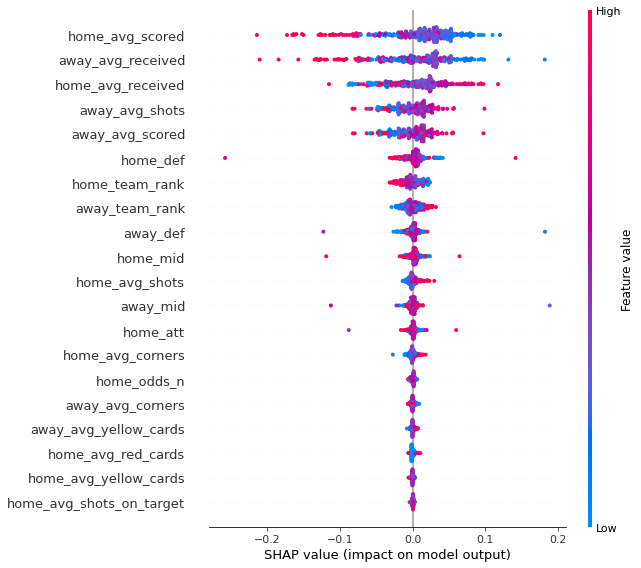

None

	Class number 1 : 1


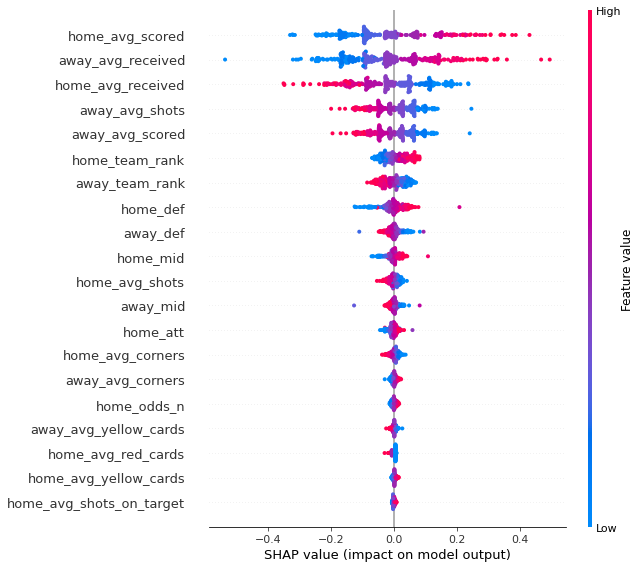

None

	Class number 2 : 2


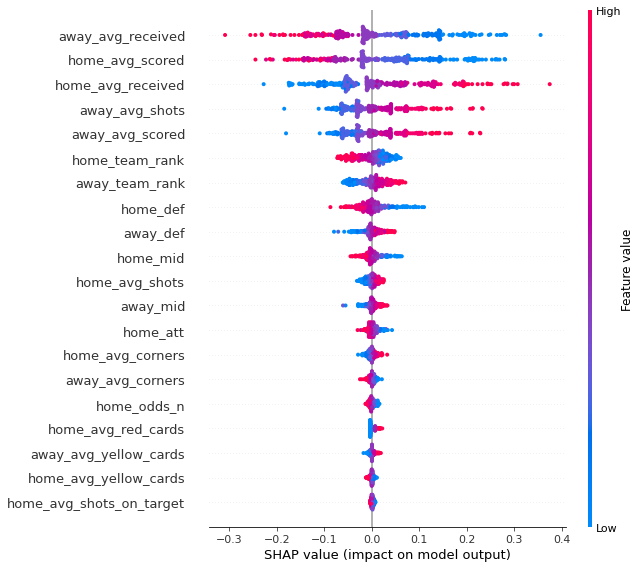

None

In [12]:
number_of_samples=300
to_explain=x_test.sample(number_of_samples).to_numpy()
shap_values = explainer.shap_values(X=to_explain,check_additivity=False)
features=to_explain

for which_class in range(0,3):
    print(f'\tClass number {which_class} : {value_to_label_dict[which_class]}')
    display(shap.summary_plot(shap_values=shap_values[which_class],
                                features=features,
                                feature_names=feature_names))

Summary plot for all the classes

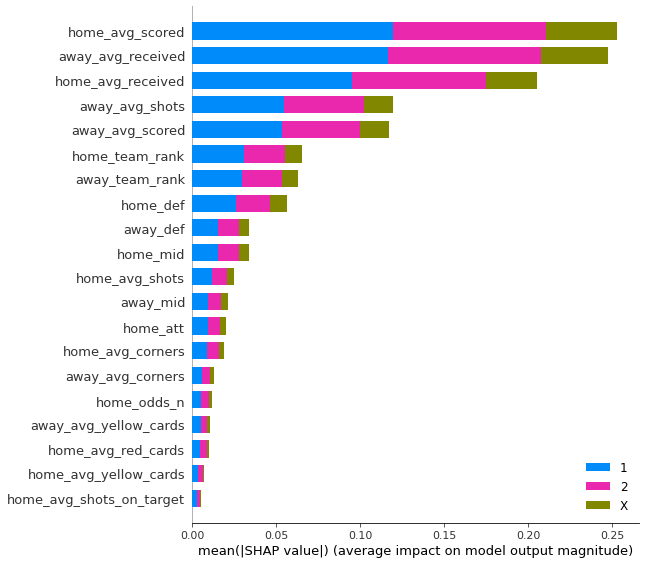

None

In [13]:
to_explain=x_test.to_numpy()
shap_values = explainer.shap_values(X=to_explain,check_additivity=False)
features=to_explain
display(shap.summary_plot(shap_values=shap_values,features=features,feature_names=feature_names,class_names=value_to_label_dict))

Section for single record explanation

#insert the record's detail
record={'away_att':[76],
        'away_def':[75],
        'away_mid':[73],
        'away_team_rank':[6],
        'away_team_received':[1.333],
        'away_team_scored':[2],
        'home_att':[83],
        'home_def':[82],
        'home_mid':[83],
        'home_team_rank':[-1],
        'home_team_received':[2],
        'home_team_scored':[0.666],
        'away_odds_n':[0.161],
        'draw_odds_n':[0.099],
        'home_odds_n':[0.739]}
record=pd.DataFrame(data=record)

#preform prediction
prediction=pd.DataFrame(data=ann.predict(record),columns=['pred_X','pred_1','pred_2'])
display(prediction)

shap_values = explainer.shap_values(X=record.to_numpy(),check_additivity=False)
features=record.to_numpy()
feature_names=list(record.columns)

for which_class in range(0,3):
    print(f'\tClass number {which_class} : {value_to_label_dict[which_class]}')
    display(shap.force_plot(base_value=explainer.expected_value[which_class].numpy(),
                            shap_values=shap_values[which_class],
                            features=features,
                            feature_names=feature_names,
                           out_names=value_to_label_dict[which_class]))
